## Setup

In [1]:
import deeptrack as DT
import imageGeneration as IG
import unet
import cv2
import numpy as np

In [6]:
#bugfix for fredrik REMOVE LATER
import tensorflow as tf
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], False)

## Generate images using our method

In [2]:
def get_image_parameters_preconfig(image_size=256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi

    particle_number = randint(2, 5)
    particle_radius_list = uniform(5, 10, particle_number)
    (particle_center_x_list, particle_center_y_list) = IG.get_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.3, 0.5, 1), ])

    image_parameters = IG.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.2, .5),
        signal_to_noise_ratio=lambda: 50,
        gradient_intensity=lambda: uniform(0, 0.1),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters


get_image_parameters_function=lambda: get_image_parameters_preconfig(image_size = 100)


batch_images,batch_labels,batch_predictions = IG.get_batch(get_image_parameters_function = get_image_parameters_function,batch_size=10) 

number_of_images_to_save = 10

for image_number,image in enumerate(batch_images):
    if image_number>=number_of_images_to_save:
        break
    
    filepath = './images/frame{}.jpg'.format(str(image_number))
    image = image*255
    cv2.imwrite(filepath,image)

cv2.destroyAllWindows()

Time taken for batch generation of size 10: 0.13358521461486816 s.


### Construct video from images


In [4]:
import cv2
import matplotlib.pyplot as plt
import os
from os.path import isfile, join

pathIn = './images/'
pathOut = 'output.mp4'
fps = 25
size = 0
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

#for sorting the file names properly
files.sort(key = lambda x: int(x[5:-4]))

for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    #inserting the frames into an image array
    frame_array.append(img)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])

out.release()
cv2.destroyAllWindows()

## Tracking and visualisation using deeptrack


In [6]:
saved_network_file_name = "DeepTrack - Example 3 - Pretrained network.h5"
dt_model = DT.load(saved_network_file_name)

video = cv2.VideoCapture("output.mp4")
(number_frames_to_be_tracked, frames, predicted_positions_wrt_frame, predicted_positions_wrt_box, 
 boxes_all) = DT.track_video("output.mp4", dt_model,box_half_size = 18,box_scanning_step = 3,frame_normalize = 0,frame_enhance = 1,number_frames_to_be_tracked = 0)



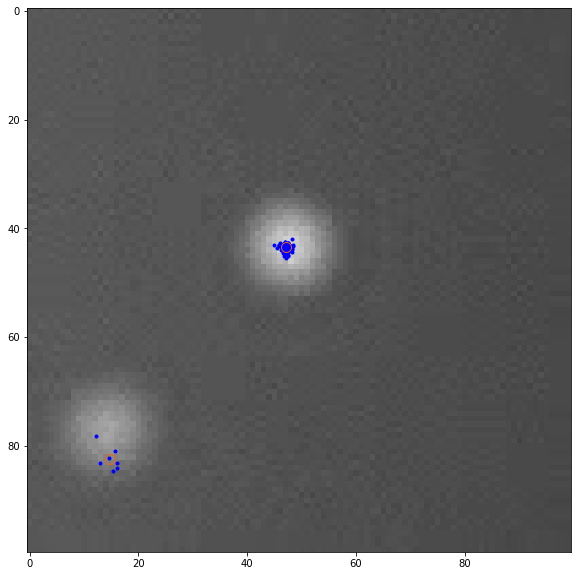

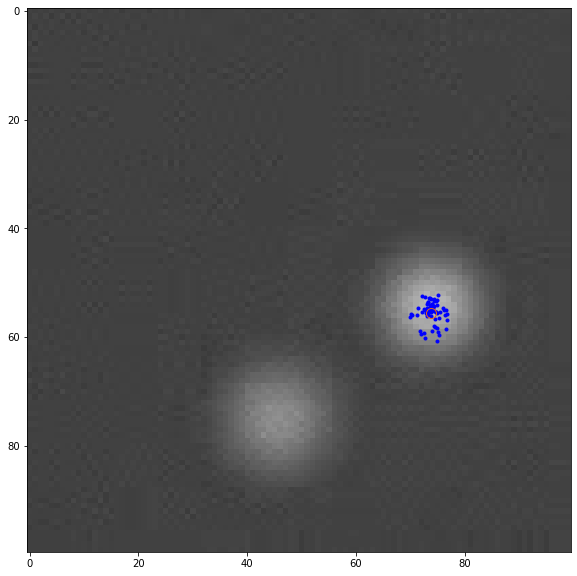

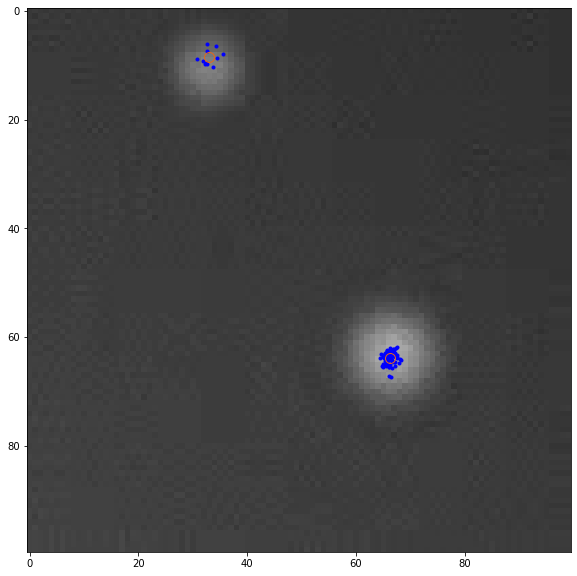

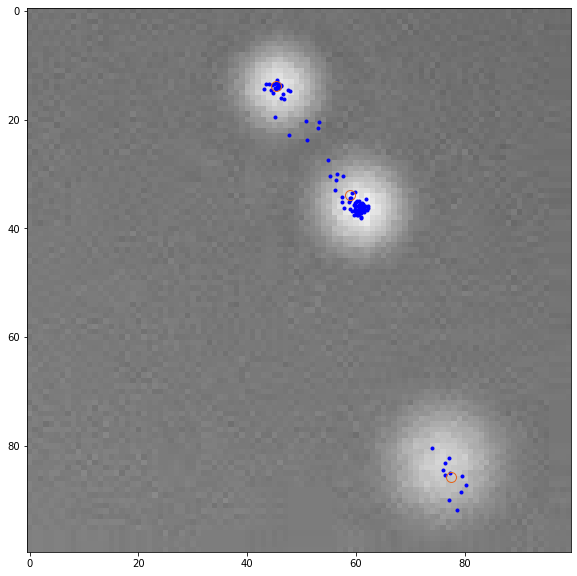

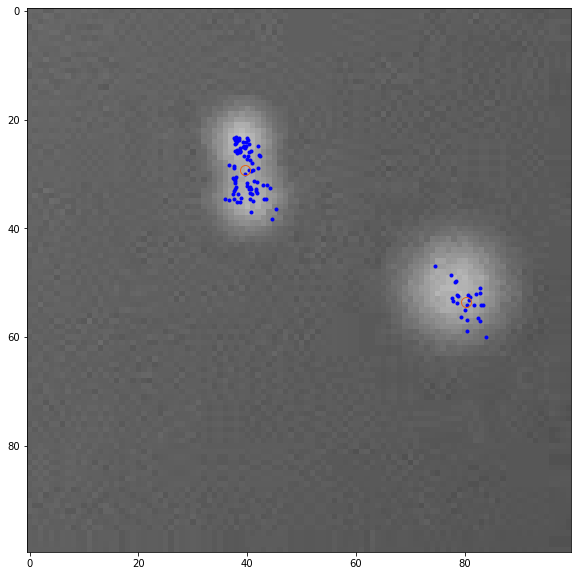

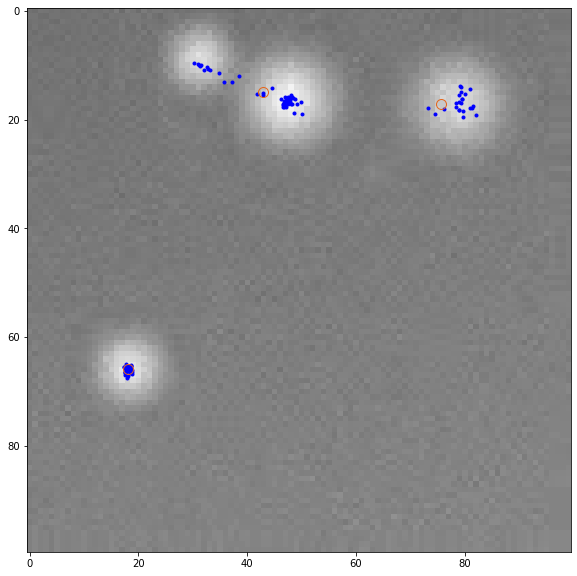

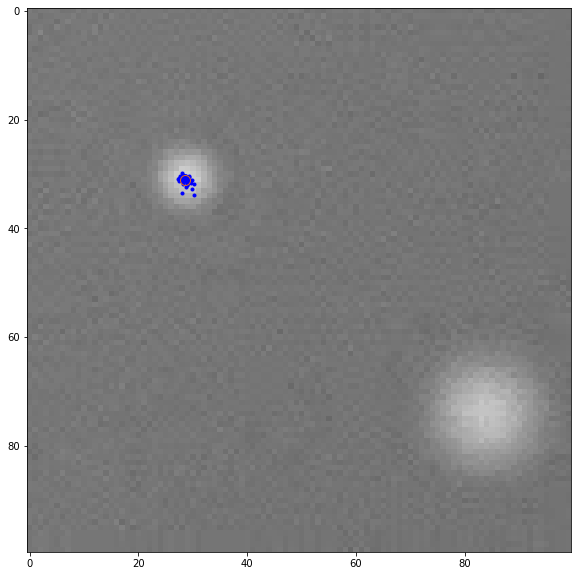

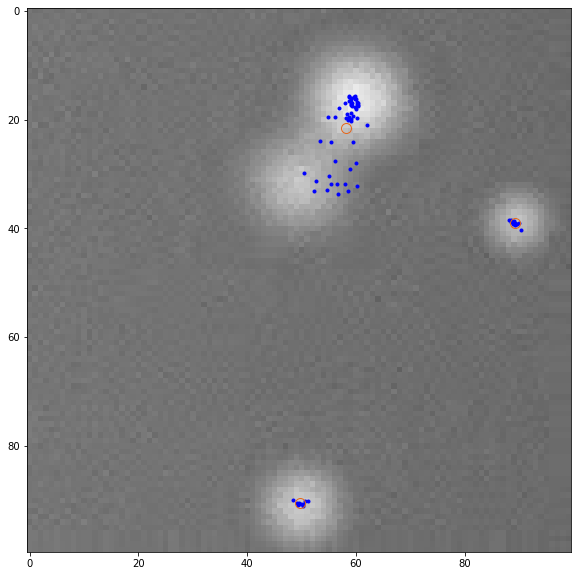

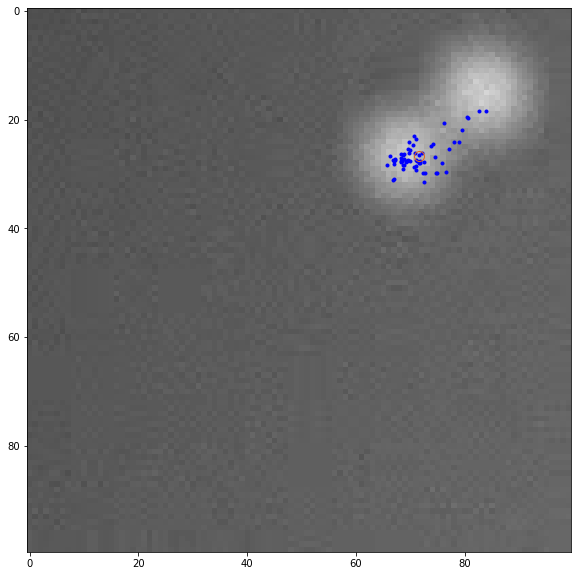

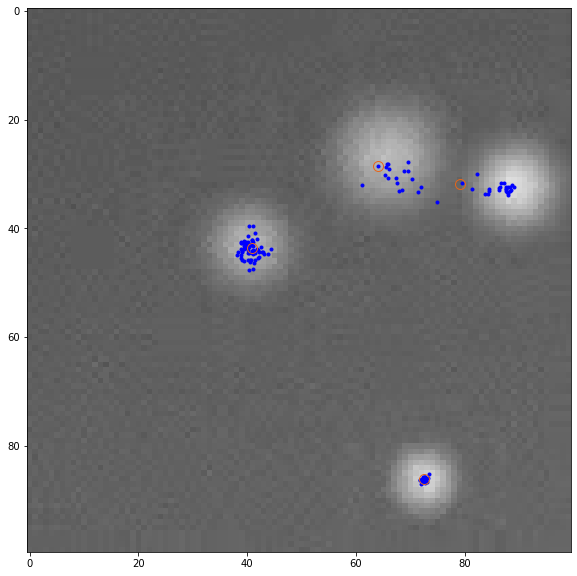

In [6]:
particle_radial_distance_threshold = 15

### Define the minumum distance between predicted scanning points for them belonging to the same particle
particle_maximum_interdistance = 24
number_tracked_frames = 10

### Visualize tracked frames
(particle_positions, particle_centroids) = DT.show_tracked_frames(particle_radial_distance_threshold, particle_maximum_interdistance,
                       number_tracked_frames, frames, predicted_positions_wrt_frame)

## generate images using Deeptrack's method

In [7]:
from numpy.random import randint, uniform, normal, choice
from math import pi

particle_number = 2

image_parameters_function = lambda : DT.get_image_parameters(
    particle_center_x_list=lambda : [normal(0 ,10, 1), 
                                     choice([int(uniform(-35, -15, 1)), int(uniform(15, 35, 1))])],
    particle_center_y_list=lambda : [normal(0 ,10, 1), 
                                     choice([int(uniform(-35, -15, 1)), int(uniform(15, 35, 1))])],
    particle_radius_list=lambda : uniform(4, 6, particle_number),
    particle_bessel_orders_list=lambda : [[1, 2], [1, 2]],
    particle_intensities_list=lambda : [[uniform(0.3, 0.7, 1), -uniform(0.2, 0.4, 1)], 
                                        [uniform(0.3, 0.7, 1), -uniform(0.3, 0.4, 1)]],
    image_half_size=lambda : 50,
    image_background_level=lambda : uniform(.2, .5),
    signal_to_noise_ratio=lambda : uniform(5, 100),
    gradient_intensity=lambda : uniform(0, 0.8),
    gradient_direction=lambda : uniform(-pi, pi),
    ellipsoidal_orientation=lambda : uniform(-pi, pi, particle_number),
    ellipticity=lambda : 1)


### Define image generator
image_generator = lambda : DT.get_image_generator(image_parameters_function)

### Show some examples of generated images
number_of_images_to_show = 5


for image_number, image, image_parameters in image_generator():
    if image_number>=number_of_images_to_show:
        break
    
    #DT.plot_sample_image(image,image_parameters)
    filepath = './images/frame{}.jpg'.format(str(image_number))
    image = image*255
    cv2.imwrite(filepath,image)

cv2.destroyAllWindows()

[[ 44.78900373  26.38510317  35.33702791]
 [ 45.04655503  31.5405843   35.28566658]
 [ 45.87683842  36.79550946  35.19855142]
 [ 47.4126184   42.07044929  35.04261374]
 [ 48.76043886  46.96017157  34.90348458]
 [ 50.0887239   51.43797919  34.82596874]
 [ 49.76445377  56.04251821  34.85360146]
 [ 48.15605521  60.64566527  35.00394821]
 [ 46.6894263   65.28126705  35.13891101]
 [ 45.79755716  70.74998233  35.2480948 ]
 [ 45.0791014   76.00139324  35.28606296]
 [ 44.98964265  81.17333569  35.31277776]
 [ 44.82482575  86.27784461  35.29903591]
 [ 44.74329926  91.42441113  35.30191779]
 [ 44.47578169  96.57460906  35.29066443]
 [ 44.44265604 101.34319104  35.30532122]
 [ 44.37751338 106.22884437  35.31226516]
 [ 44.50345948 111.41358189  35.33310294]
 [ 44.67058867 116.33044701  35.35333872]
 [ 44.72196341 121.3305001   35.34083366]
 [ 44.80880998 126.35010704  35.29109657]
 [ 44.7170803  131.45356134  35.27659178]
 [ 44.91469502 136.08816251  35.29946506]
 [ 44.60086986 141.65523272  35.32

## Predict using our version

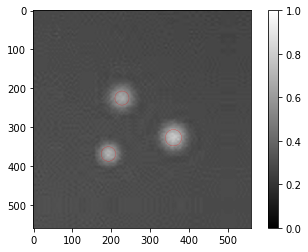

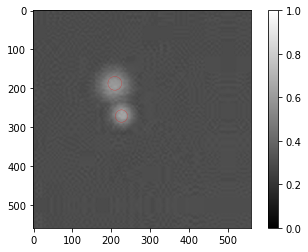

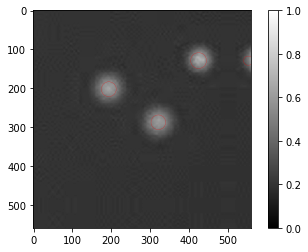

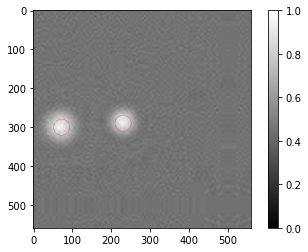

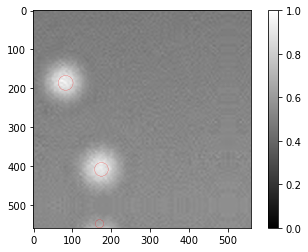

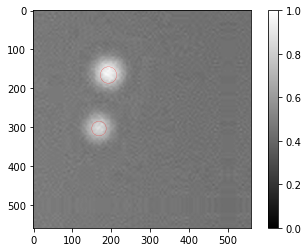

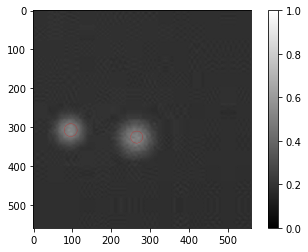

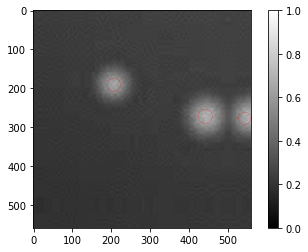

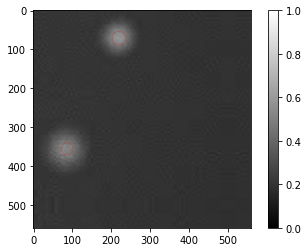

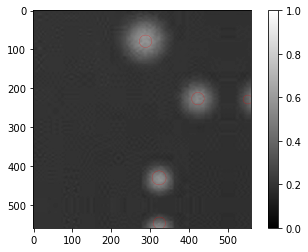

In [14]:

video = cv2.VideoCapture("output.mp4")
number_frames_to_be_tracked = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

batch_images = np.zeros((number_frames_to_be_tracked,video_height,video_width,1))


for i in range(number_frames_to_be_tracked):
    (ret, frame) = video.read()
    batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

def get_padded_images(batch_images):
    from numpy import zeros, ceil, pad
    batch_height = batch_images[0, :, :, 0].shape[0]
    batch_width = batch_images[0, :, :, 0].shape[1]
    number_of_images = batch_images.shape[0]

    if batch_height % 16 != 0 or batch_width % 16 != 0:
        n1 = 16 - batch_height % 16
        n2 = 16 - batch_width % 16
        
        padding_tuple = ((0, 0), (0, n1), (0, n2), (0,0))
        padded_images = pad(batch_images, padding_tuple, mode='symmetric')

    else:
        padded_images = batch_images
    return padded_images


def predict(model,batch_images):
    padded_images = get_padded_images(batch_images)

    return model.predict(padded_images)


model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")
batch_predictions = predict(model,batch_images)

batch = (get_padded_images(batch_images),None,batch_predictions)

for i in range(number_frames_to_be_tracked):
    IG.visualise_batch(batch,apply_cutoff = True,cutoff_value = 0.95,index_of_image_to_show=i)

## Predicions side by side

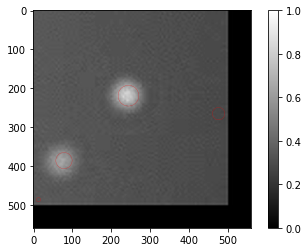

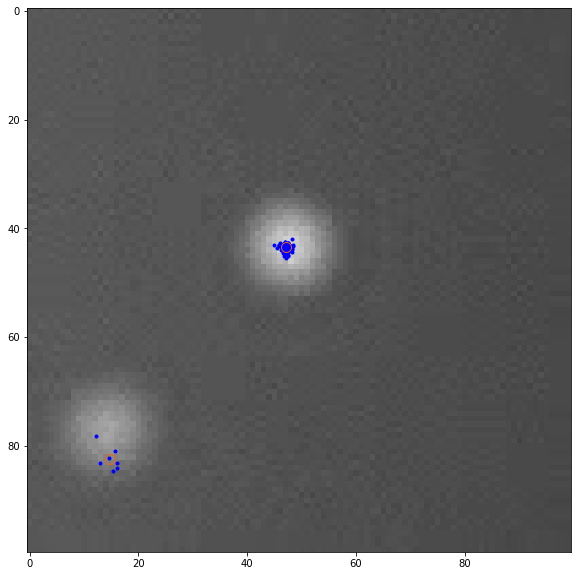

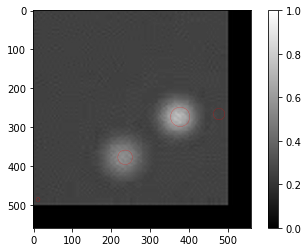

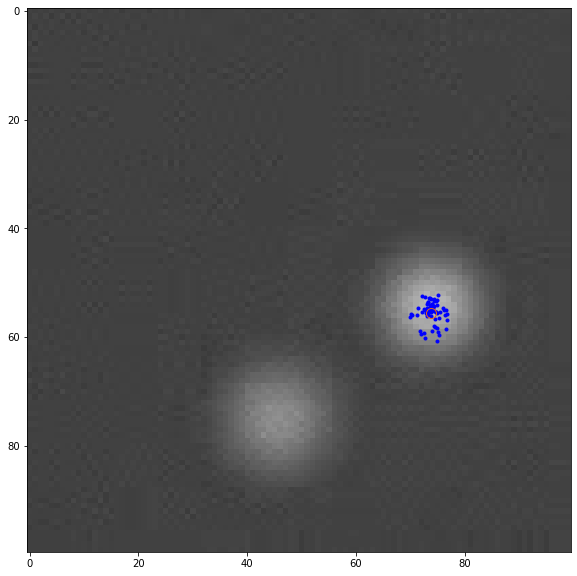

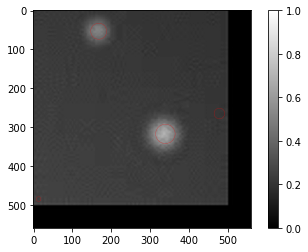

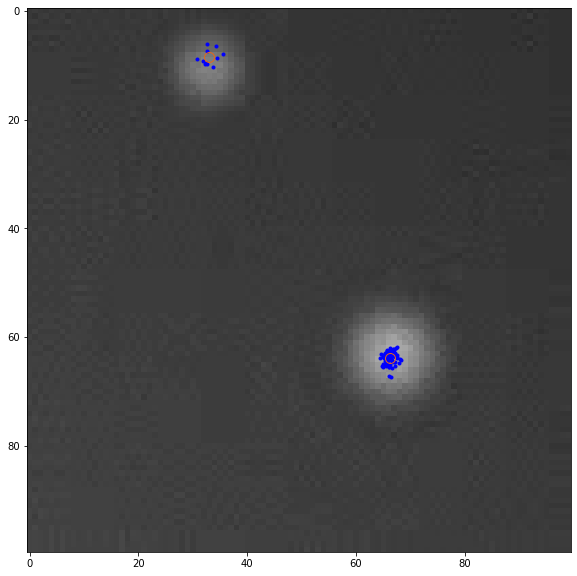

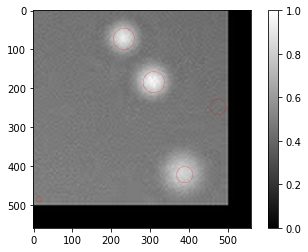

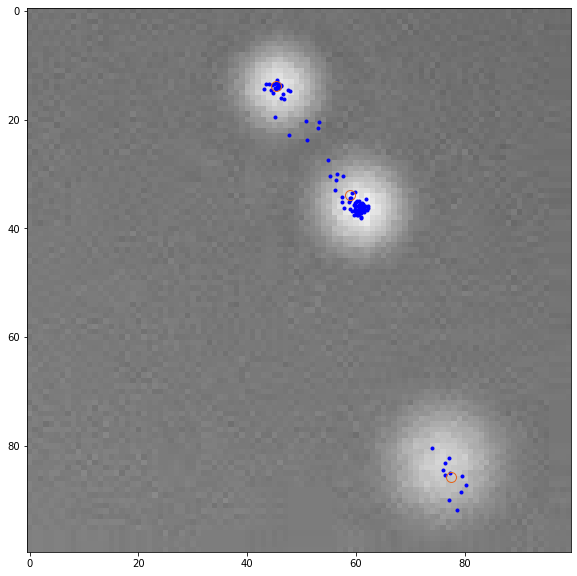

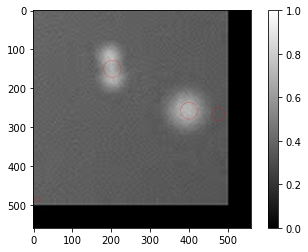

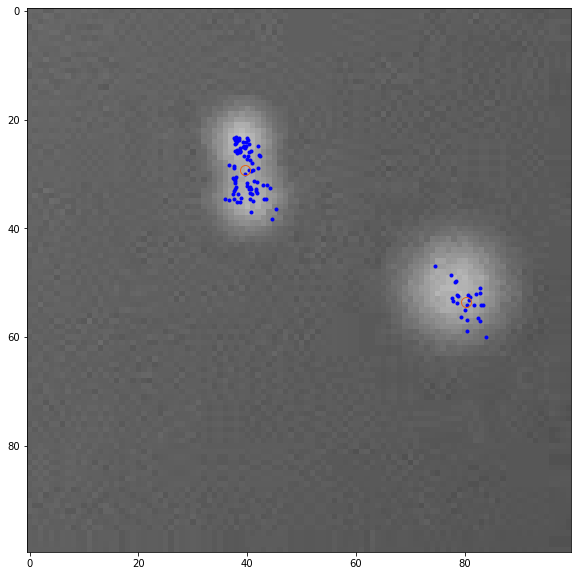

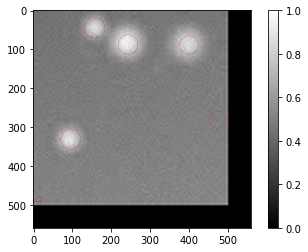

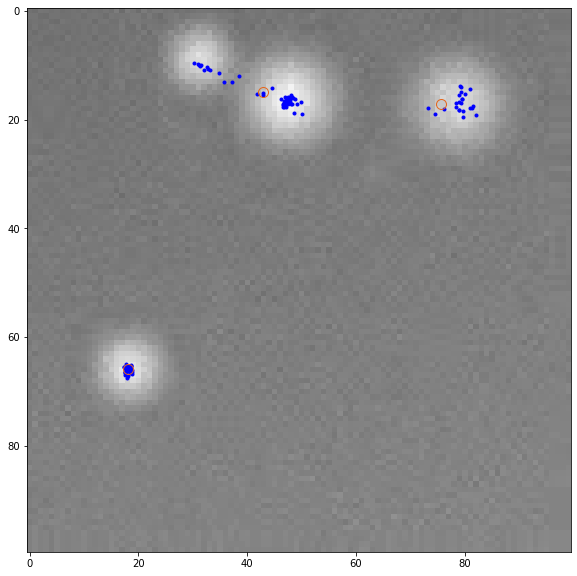

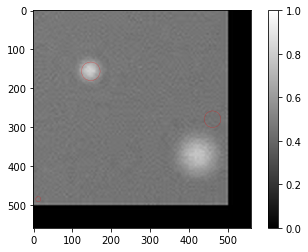

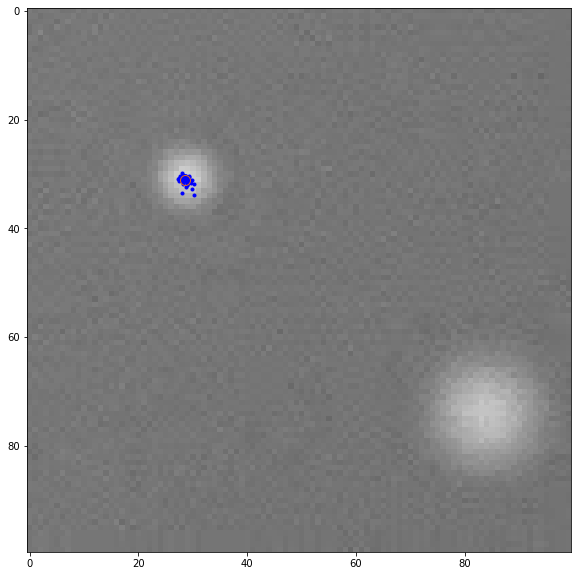

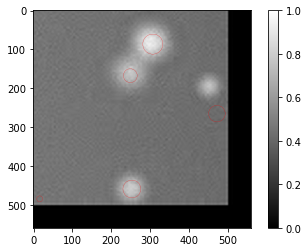

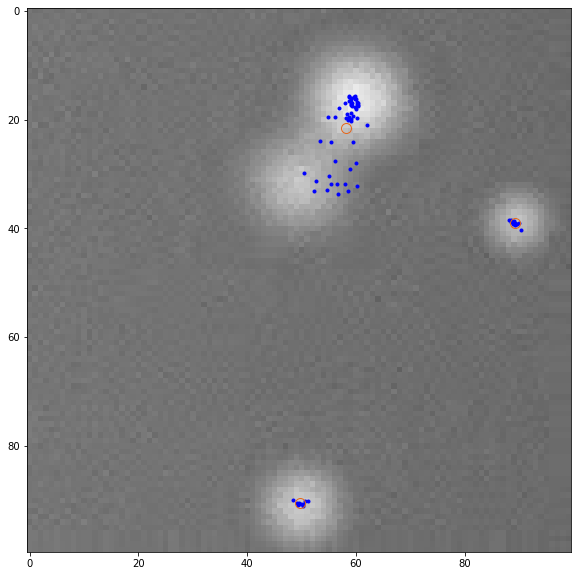

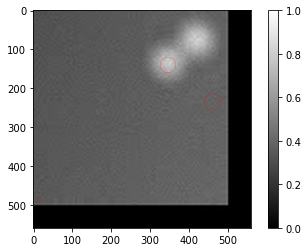

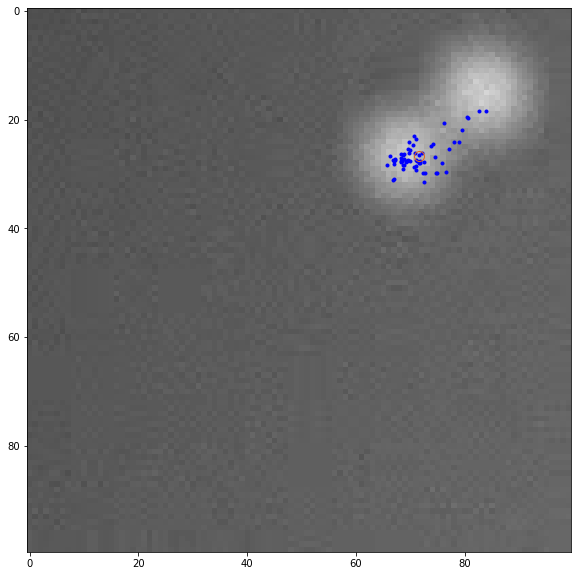

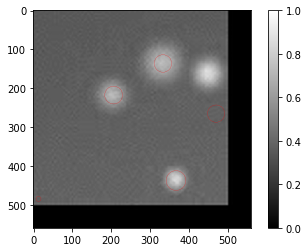

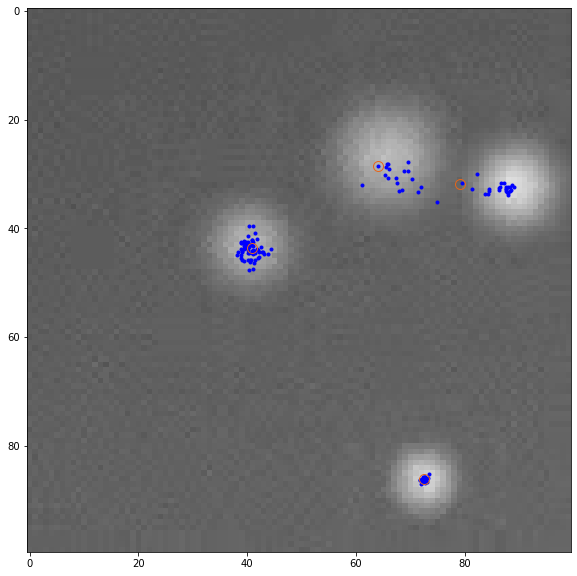

In [34]:
#TODO: få bilderna att visas sida vid sida elr åtminstone i samma/rimlig storlek



video = cv2.VideoCapture("output.mp4")

saved_network_file_name = "DeepTrack - Example 3 - Pretrained network.h5"
dt_model = DT.load(saved_network_file_name)
(number_frames_to_be_tracked, frames, predicted_positions_wrt_frame, predicted_positions_wrt_box, 
 boxes_all) = DT.track_video("output.mp4", dt_model,box_half_size = 18,box_scanning_step = 3,frame_normalize = 0,frame_enhance = 1,number_frames_to_be_tracked = 0)

particle_radial_distance_threshold = 15

### Define the minumum distance between predicted scanning points for them belonging to the same particle
particle_maximum_interdistance = 24



number_frames_to_be_tracked = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

batch_images = np.zeros((number_frames_to_be_tracked,video_height,video_width,1))

for i in range(number_frames_to_be_tracked):
    (ret, frame) = video.read()
    batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")
batch_predictions = unet.predict(model,batch_images)

batch = (unet.get_padded_images(batch_images),None,batch_predictions)

for i in range(number_frames_to_be_tracked):
    IG.visualise_batch(batch,apply_cutoff = True,cutoff_value = 0.95,index_of_image_to_show=i)
    plt.show()
    
    number_tracked_frames = 1
    frame = frames[i:i+1,:,:]
    predicted_position_wrt_frame = predicted_positions_wrt_frame[i:i+1,:,:,:]
    
    DT.show_tracked_frames(particle_radial_distance_threshold, particle_maximum_interdistance,
                       number_tracked_frames, frame, predicted_position_wrt_frame)
    plt.show()
    
    